# **Použité knihovny**

In [2]:
import pandas as pd
!pip3 install rdkit-pypi
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import time
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import torch
import torch.nn as nn
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from torch.utils.data import TensorDataset
from sklearn.feature_selection import VarianceThreshold
import torch
import seaborn as sns

     |████████████████████████████████| 20.6 MB 6.2 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data**
Vstupní data obsahuji 5 sloupcu, jsou to sloučeniny u kterych zname jejich biologickou aktivitu na receptor LXRb

Popis slopců:
  1. smiles - zapis sloučeninu pomoci smiles
  2. chembl_id - idečko
  3. potency - míra jak je aktivní sloučenina na receptor
  4. pec50 - koncentrace ligandu, ktera vyvolava maximální poloviční odezvu a prevedeme to na logaritmus s základem 10.Tenhle sloupeček budeme chtit predikovat
  5. category - sloupeček který nam říka jestli je sloučenina aktivní nebo ne.


In [4]:
df = pd.read_csv("drive/MyDrive/MVI/semestralka/LXRb_ch25_curated_DW_2.csv")

In [5]:
df[:3]

smiles  ...  category
0   Cc1cc2c(cc1C(=C)c3ccc(cc3)C(=O)O)C(C)(C)CCC2(C)C  ...    active
1  CCc1nc2c(cccc2nc1c3ccc(cc3)c4cccc(c4)S(=O)(=O)...  ...  inactive
2  CS(=O)(=O)c1cccc(c1)c2ccc(CN(Cc3ccc(F)cc3Cl)S(...  ...    active

[3 rows x 5 columns]

In [6]:
print("Počet molekul v data setu: ", len(df))

Počet molekul v data setu:  1080


## **Zpracování dat**

Převedeme naši smile do Morganova fingerprintu, což je bitový vector velikosti 1024, který udržuje informaci o tom jestli například sloučenina obsahuje určitou funkční skupinu nebo ne. Je to takove zakodování sloučeniny do bitového vectoru

In [7]:
#funkce převodu smiles na Morganuv_fingerprint
def morgan_fing(mol):
  mf=AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=1024)
  array=np.array(mf)
  return array

In [8]:
df['molecule'] = [Chem.MolFromSmiles(mol) for mol in df['smiles']]
df['bin']= df.molecule.apply(morgan_fing)
df.head(3)


smiles  ...                                                bin
0   Cc1cc2c(cc1C(=C)c3ccc(cc3)C(=O)O)C(C)(C)CCC2(C)C  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1  CCc1nc2c(cccc2nc1c3ccc(cc3)c4cccc(c4)S(=O)(=O)...  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2  CS(=O)(=O)c1cccc(c1)c2ccc(CN(Cc3ccc(F)cc3Cl)S(...  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

[3 rows x 7 columns]

V dalším kroku rozdělím dataset na trenovaci a testovaci mnnožinu, připadně ještě validační. Použijeme funkci ***divide_the_data_into_two_sets***

In [9]:
def divide_the_data_into_two_sets(df, ran_state):
    
    train, test = train_test_split(df, test_size=0.2, random_state=ran_state ,stratify = df['category_new'])
    train =train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    return train, test

Nejprvé vytvoříme novou kategorii, což znamena že nastavíme threshold, kdy budeme počitat že je sloučenína aktivní a neaktivní. Vezmeme pro začatek 6, ale jinak dá se to měnit v rozumnych rozmezich od 5-7

In [10]:
thre=6.0
df['category_new'] = np.where(df['pec50']>=thre, 1, 0)

In [11]:
train_set_cely, test_set = divide_the_data_into_two_sets(df ,2)
train_set, valid_set = divide_the_data_into_two_sets(train_set_cely, 2)
print("Train shape:",train_set.shape)
print("Test shape:",test_set.shape)
print("Valid shape:",valid_set.shape)

Train shape: (691, 8)
Test shape: (216, 8)
Valid shape: (173, 8)


In [12]:
train_set[:3]

smiles  ... category_new
0              Cc1ccnc(NC(=O)\C=C\c2cccs2)c1  ...            0
1  Cc1cc(ccc1NS(=O)(=O)c2cccs2)c3nc4cccnc4s3  ...            0
2                COCCNc1nc(cs1)c2oc3ccccc3c2  ...            0

[3 rows x 8 columns]

Vykreslíme pár molekul, abychom měli představu jak vypadaji a aby ten kod byl spojen s nějakými krasnými obrazkami:)

[<Figure size 86.4x86.4 with 1 Axes>,
 <Figure size 86.4x86.4 with 1 Axes>,
 <Figure size 86.4x86.4 with 1 Axes>]

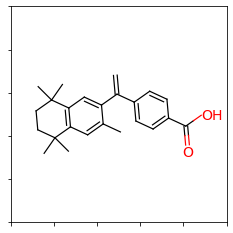

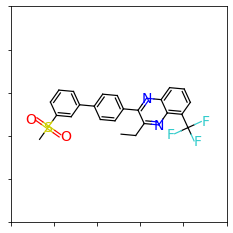

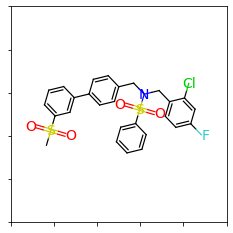

In [13]:
[Draw.MolToMPL(df['molecule'].loc[x], size=(120,120)) for x in range(3)]


# **Funkce které jsou společné pro všechny následující modely**

In [14]:
def x_y_set(df,features):
  ''' Funkce: pro extrahování sloupce, které budeme potřebovat pro predikci, použijeme vždy sloupec bin a pec50 nebo new_category '''

  ret=df[features].values
  return ret

# Plot true future vs prediction
def plot_future(prediction, y_test, name_model):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.title(name_model)
    plt.xlabel('Compounds')
    plt.ylabel('PEC50')

def evaluate_prediction(predictions, actual, model_name,x,res):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean squared error: {:.4f}'.format(mse))
    if x != 0:
      res = res.append({'Metoda':model_name,'MSE': mse,'MAE': mae,'RMSE':rmse},ignore_index=True)
      return res

def barplot(res, problem):
  if problem=="clas":
      
      res = res[['Metoda','Accur','F1']]      
      tidy = res.melt(id_vars='Metoda').rename(columns=str.title)
      fig, ax1 = plt.subplots(figsize=(7, 7))
      ax = sns.barplot(x="Metoda", y="Value", hue='Variable', data=tidy, ax=ax1)
      for p in ax.patches:                 
          annotation = '{:.3f}'.format(p.get_height())
          x = (p.get_x() + p.get_width()/4)
          y = (p.get_y() + (p.get_height()/4)*3)
          ax.annotate(annotation, (x, y),size = 15, rotation=90,fontsize=20)
      ax.set_xticklabels(ax.get_xticklabels(), rotation=70,fontsize=20)
      ax.set_title("Klasifikační úloha",fontsize=20)
      ax.set_xlabel("Metoda",fontsize=20)
      ax.set_ylabel("Value",fontsize=20)
      ax.tick_params(axis="x", labelsize=17)
      ax.tick_params(axis="y", labelsize=17)
      ax.legend(fontsize=14)
      sns.despine(fig)

  elif problem=='reg':
      res = res[['Metoda','MSE','MAE','RMSE']]      
      tidy = res.melt(id_vars='Metoda').rename(columns=str.title)
      fig, ax1 = plt.subplots(figsize=(7, 7))
      ax = sns.barplot(x="Metoda", y="Value", hue='Variable', data=tidy, ax=ax1)
      for p in ax.patches:                 
          annotation = '{:.3f}'.format(p.get_height())
          x = (p.get_x() + p.get_width()/4)
          y = (p.get_y() + (p.get_height()/4)*3)
          ax.annotate(annotation, (x, y),size = 15, rotation=90,fontsize=15)
      ax.set_xticklabels(ax.get_xticklabels(), rotation=70,fontsize=20)
      ax.set_title("Regresní úloha", fontsize=20)
      ax.set_xlabel("Metoda",fontsize=20)
      ax.set_ylabel("Value",fontsize=20)
      ax.tick_params(axis="x", labelsize=17)
      ax.tick_params(axis="y", labelsize=17)
      ax.legend(fontsize=14)
      sns.despine(fig)



# **Regressní predikce**
Nejprvé zkusíme regresní predikci, a pak klasifikační.
Zkusím Keras,Keras_LSTM,Random Forest.

A porovnam mezi sebou)


# **DNN**
3 skryté vrstvy první dvě mají 200 neuronu, dalši 50

Počet epoch = 200, batch size = 50

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, LSTM, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

In [16]:
x_train_nn=np.stack(x_y_set(train_set,'bin'))
y_train_nn=x_y_set(train_set,'pec50').reshape((-1,1))
x_test_nn=np.stack(x_y_set(test_set,'bin'))
y_test_nn=x_y_set(test_set,'pec50').reshape((-1,1))
x_valid_nn=np.stack(x_y_set(valid_set,'bin'))
y_valid_nn=x_y_set(valid_set,'pec50').reshape((-1,1))

In [17]:
print(x_train_nn.shape)
print(x_valid_nn.shape)
print(x_test_nn.shape)

(691, 1024)
(173, 1024)
(216, 1024)


Normalizace pomoci StandardScaler()

In [18]:
scaler = StandardScaler()

y_train_nn=scaler.fit_transform(y_train_nn)
y_test_nn=scaler.fit_transform(y_test_nn)
y_valid_nn=scaler.fit_transform(y_valid_nn)

In [19]:
y_train_nn.shape

(691, 1)

In [20]:
def model_nn(): 

  model = Sequential()
  model.add(Dense(200, input_dim=1024, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(200, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(50, activation=tf.nn.relu))
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mse', optimizer='adam')
  
  print(model.summary())
  return model

In [21]:
model_nn = model_nn()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               205000    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                10050     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 255,301
Trainable params: 255,301
Non-trai

In [22]:
history = model_nn.fit(x_train_nn, y_train_nn,
                    epochs=200,
                    batch_size=50,
                    validation_data=(x_valid_nn, y_valid_nn),
                    verbose = 0
                   )

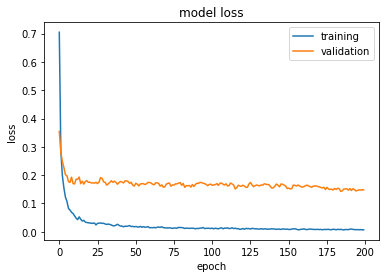

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [24]:
def predict_smiles_nn(smiles):
    x_input =morgan_fing(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    print(x_input)

    
    print(x_input.shape)
    
    pec50 = scaler.inverse_transform(model_nn.predict(x_input, verbose=0))
    return pec50[0][0]
#predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')
a = predict_smiles_nn('Cc1cc2c(cc1C(=C)c3ccc(cc3)C(=O)O)C(C)(C)CCC2(C)C')
a

[[0 0 0 ... 0 1 0]]
(1, 1024)


6.43388

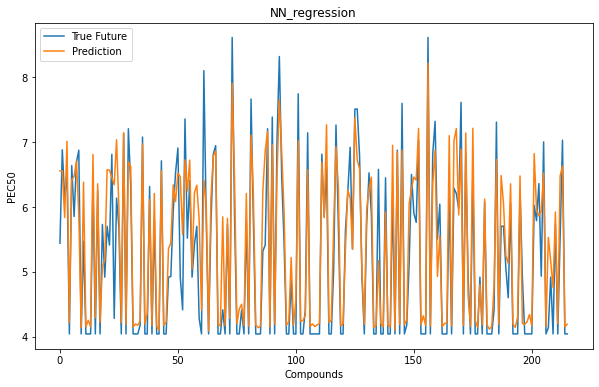

In [25]:
def prediction_nn(model):
    
    prediction = model.predict(x_test_nn)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_test_nn = prediction_nn(model_nn)



plot_future(prediction_test_nn, scaler.inverse_transform(y_test_nn), "NN_regression")

In [26]:
evaluate_prediction(prediction_test_nn,scaler.inverse_transform(y_test_nn), 'NN',0, '')

NN:
Mean Absolute Error: 0.3712
Root Mean Square Error: 0.5123
Mean squared error: 0.2625


In [27]:
evaluate_prediction(prediction_test_nn,np.array(test_set.pec50).reshape((-1,1)), 'NN',0,'')

NN:
Mean Absolute Error: 0.3076
Root Mean Square Error: 0.4761
Mean squared error: 0.2266


# **DNN_ARCHITEKTURA 2**

*   3 skryte vrstvy, vsechny maji 500 neuronu
*   Počet epoch 200, betch size= 50



In [28]:
x_train_nn=np.stack(x_y_set(train_set,'bin'))
y_train_nn=x_y_set(train_set,'pec50').reshape((-1,1))
x_test_nn=np.stack(x_y_set(test_set,'bin'))
y_test_nn=x_y_set(test_set,'pec50').reshape((-1,1))
x_valid_nn=np.stack(x_y_set(valid_set,'bin'))
y_valid_nn=x_y_set(valid_set,'pec50').reshape((-1,1))

In [29]:
scaler = StandardScaler()

y_train_nn=scaler.fit_transform(y_train_nn)
y_test_nn=scaler.fit_transform(y_test_nn)
y_valid_nn=scaler.fit_transform(y_valid_nn)

In [30]:
def model_nn_2(): 

  model = Sequential()
  model.add(Dense(500, input_dim=1024, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(500, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(500, activation=tf.nn.relu))
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mse', optimizer='adam')
  
  print(model.summary())
  return model

In [31]:
model_nn_2 = model_nn_2()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 500)               512500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 500)               250500    
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 500)               250500    
                                                                 
 dense_7 (Dense)             (None, 1)                 501       
                                                                 
Total params: 1,014,001
Trainable params: 1,014,001
No

In [32]:
history = model_nn_2.fit(x_train_nn, y_train_nn,
                    epochs=200,
                    batch_size=50,
                    validation_data=(x_valid_nn, y_valid_nn),
                    verbose = 0
                   )

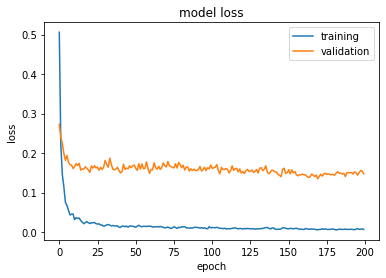

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [34]:
def predict_smiles_nn(smiles):
    x_input =morgan_fing(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    print(x_input)

    
    print(x_input.shape)
    
    pec50 = scaler.inverse_transform(model_nn_2.predict(x_input, verbose=0))
    return pec50[0][0]
#predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')
a = predict_smiles_nn('Cc1cc2c(cc1C(=C)c3ccc(cc3)C(=O)O)C(C)(C)CCC2(C)C')
a

[[0 0 0 ... 0 1 0]]
(1, 1024)


6.3361406

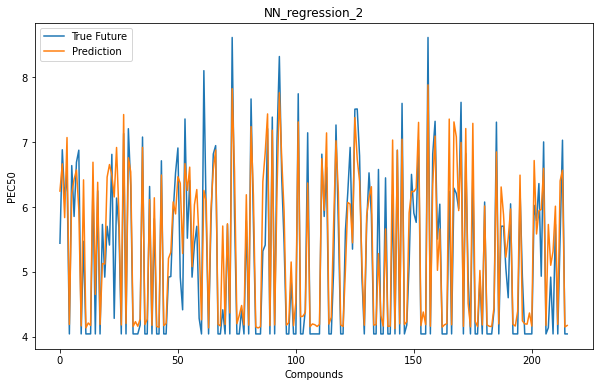

In [35]:
def prediction_nn(model):
    
    prediction = model.predict(x_test_nn)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_test_nn_2 = prediction_nn(model_nn_2)



plot_future(prediction_test_nn_2, scaler.inverse_transform(y_test_nn), "NN_regression_2")

In [36]:
evaluate_prediction(prediction_test_nn_2,scaler.inverse_transform(y_test_nn), 'NN_2',0, '')

NN_2:
Mean Absolute Error: 0.3672
Root Mean Square Error: 0.5055
Mean squared error: 0.2556


In [37]:
evaluate_prediction(prediction_test_nn_2,np.array(test_set.pec50).reshape((-1,1)), 'NN_2',0,'')

NN_2:
Mean Absolute Error: 0.3021
Root Mean Square Error: 0.4697
Mean squared error: 0.2206


# **DNN architectura 3**
3 skryte vrstvy, kazda ma 1500 neuronu, pocet epoch 200, betch size =50

In [38]:
x_train_nn=np.stack(x_y_set(train_set,'bin'))
y_train_nn=x_y_set(train_set,'pec50').reshape((-1,1))
x_test_nn=np.stack(x_y_set(test_set,'bin'))
y_test_nn=x_y_set(test_set,'pec50').reshape((-1,1))
x_valid_nn=np.stack(x_y_set(valid_set,'bin'))
y_valid_nn=x_y_set(valid_set,'pec50').reshape((-1,1))

scaler = StandardScaler()

y_train_nn=scaler.fit_transform(y_train_nn)
y_test_nn=scaler.fit_transform(y_test_nn)
y_valid_nn=scaler.fit_transform(y_valid_nn)

In [39]:
def model_nn_3(): 

  model = Sequential()
  model.add(Dense(1500, input_dim=1024, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(1500, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(1500, activation=tf.nn.relu))
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mse', optimizer='adam')
  
  print(model.summary())
  return model

In [40]:
model_nn_3 = model_nn_3()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1500)              1537500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_9 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_5 (Dropout)         (None, 1500)              0         
                                                                 
 dense_10 (Dense)            (None, 1500)              2251500   
                                                                 
 dense_11 (Dense)            (None, 1)                 1501      
                                                                 
Total params: 6,042,001
Trainable params: 6,042,001
No

In [41]:
history = model_nn_3.fit(x_train_nn, y_train_nn,
                    epochs=200,
                    batch_size=50,
                    validation_data=(x_valid_nn, y_valid_nn),
                    verbose = 0
                   )

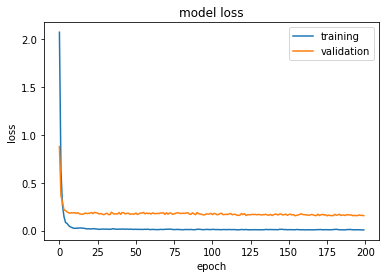

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [43]:
def predict_smiles_nn(smiles):
    x_input =morgan_fing(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    print(x_input)

    
    print(x_input.shape)
    
    pec50 = scaler.inverse_transform(model_nn_3.predict(x_input, verbose=0))
    return pec50[0][0]
#predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')
a = predict_smiles_nn('Cc1cc2c(cc1C(=C)c3ccc(cc3)C(=O)O)C(C)(C)CCC2(C)C')
a

[[0 0 0 ... 0 1 0]]
(1, 1024)


6.381557

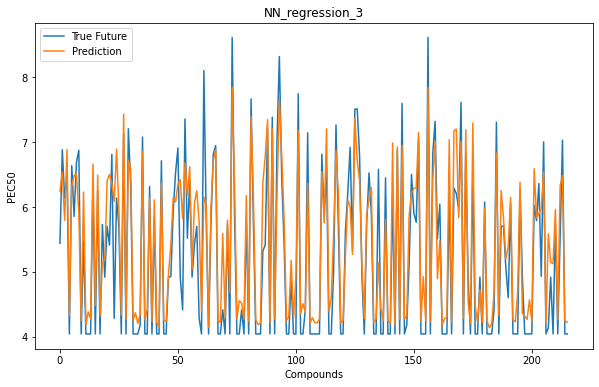

In [44]:
def prediction_nn(model):
    
    prediction = model.predict(x_test_nn)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_test_nn_3 = prediction_nn(model_nn_3)



plot_future(prediction_test_nn_3, scaler.inverse_transform(y_test_nn), "NN_regression_3")

In [45]:
evaluate_prediction(prediction_test_nn_3,scaler.inverse_transform(y_test_nn), 'NN_3',0, '')

NN_3:
Mean Absolute Error: 0.4056
Root Mean Square Error: 0.5243
Mean squared error: 0.2748


In [46]:
evaluate_prediction(prediction_test_nn_3,np.array(test_set.pec50).reshape((-1,1)), 'NN_3',0,'')

NN_3:
Mean Absolute Error: 0.3371
Root Mean Square Error: 0.4794
Mean squared error: 0.2299


# **DNN_4**
4 skryte vrstvy, kazda ma 500 neuronu, pocet epoch= 200, batch_size=50

In [47]:
x_train_nn=np.stack(x_y_set(train_set,'bin'))
y_train_nn=x_y_set(train_set,'pec50').reshape((-1,1))
x_test_nn=np.stack(x_y_set(test_set,'bin'))
y_test_nn=x_y_set(test_set,'pec50').reshape((-1,1))
x_valid_nn=np.stack(x_y_set(valid_set,'bin'))
y_valid_nn=x_y_set(valid_set,'pec50').reshape((-1,1))

scaler = StandardScaler()

y_train_nn=scaler.fit_transform(y_train_nn)
y_test_nn=scaler.fit_transform(y_test_nn)
y_valid_nn=scaler.fit_transform(y_valid_nn)

In [48]:
def model_nn_4(): 

  model = Sequential()
  model.add(Dense(500, input_dim=1024, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(500, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(500, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(500, activation=tf.nn.relu))
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mse', optimizer='adam')
  
  print(model.summary())
  return model

In [49]:
model_nn_4 = model_nn_4()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 500)               512500    
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_13 (Dense)            (None, 500)               250500    
                                                                 
 dropout_7 (Dropout)         (None, 500)               0         
                                                                 
 dense_14 (Dense)            (None, 500)               250500    
                                                                 
 dropout_8 (Dropout)         (None, 500)               0         
                                                                 
 dense_15 (Dense)            (None, 500)              

In [50]:
history = model_nn_4.fit(x_train_nn, y_train_nn,
                    epochs=200,
                    batch_size=50,
                    validation_data=(x_valid_nn, y_valid_nn),
                    verbose = 0
                   )

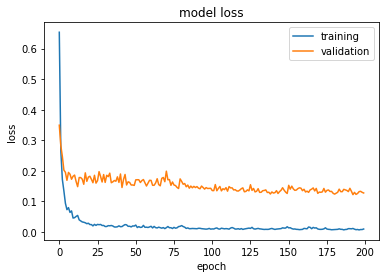

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

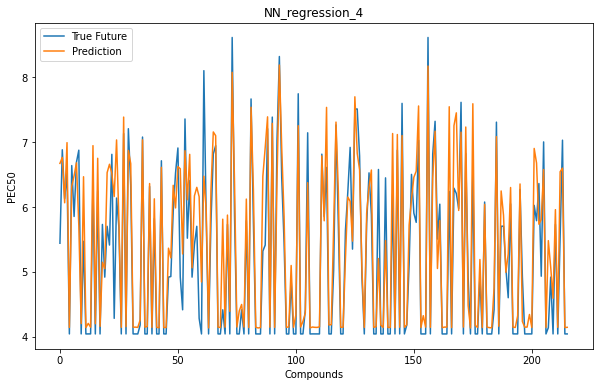

In [52]:
def prediction_nn(model):
    
    prediction = model.predict(x_test_nn)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_test_nn_4 = prediction_nn(model_nn_4)



plot_future(prediction_test_nn_4, scaler.inverse_transform(y_test_nn), "NN_regression_4")

In [53]:
evaluate_prediction(prediction_test_nn_4,scaler.inverse_transform(y_test_nn), 'NN_4',0, '')

NN_4:
Mean Absolute Error: 0.3596
Root Mean Square Error: 0.5230
Mean squared error: 0.2735


In [54]:
evaluate_prediction(prediction_test_nn_4,np.array(test_set.pec50).reshape((-1,1)), 'NN_4',0,'')

NN_4:
Mean Absolute Error: 0.3079
Root Mean Square Error: 0.4933
Mean squared error: 0.2434


# **XGBoost**

Uděláme XGBoost a pak porovnám všechny modely mezi sebou

In [55]:
import sklearn.metrics as metrics
from xgboost import XGBRegressor


In [56]:
x_train_xg=np.stack(x_y_set(train_set_cely,'bin'))
y_train_xg=x_y_set(train_set_cely,'pec50').reshape((-1,1))
x_test_xg=np.stack(x_y_set(test_set,'bin'))
y_test_xg=x_y_set(test_set,'pec50').reshape((-1,1))


In [57]:
x_train_xg.shape

(864, 1024)

In [58]:
scaler = StandardScaler()

y_train_xg=scaler.fit_transform(y_train_xg)
y_test_xg=scaler.fit_transform(y_test_xg)


In [59]:
model = XGBRegressor().fit(x_train_xg, y_train_xg)

[14:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


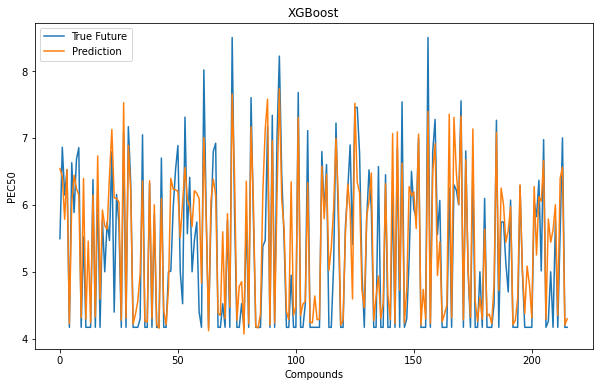

In [60]:
def prediction_xgboost():
    prediction = model.predict(x_test_xg)
    prediction = prediction.reshape((-1,1))
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_test_xgboost = prediction_xgboost()
plot_future(prediction_test_xgboost, scaler.inverse_transform(y_test_xg), "XGBoost")


In [61]:
evaluate_prediction(prediction_test_xgboost,scaler.inverse_transform(y_test_xg), 'XGBoost',0,'')

XGBoost:
Mean Absolute Error: 0.4058
Root Mean Square Error: 0.5561
Mean squared error: 0.3093


In [62]:
evaluate_prediction(prediction_test_xgboost,np.array(test_set.pec50).reshape((-1,1)), 'XGBoost',0,'')

XGBoost:
Mean Absolute Error: 0.4058
Root Mean Square Error: 0.5561
Mean squared error: 0.3093


# **Porovnání víc modelů:**

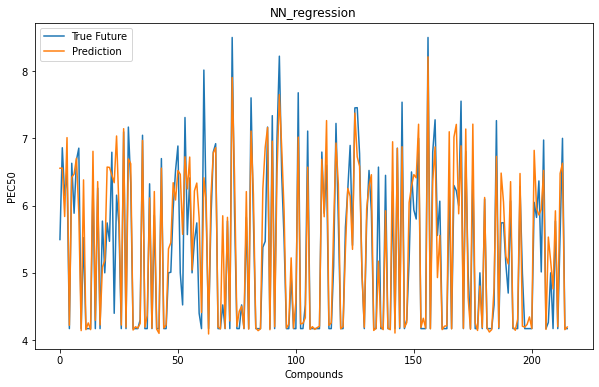

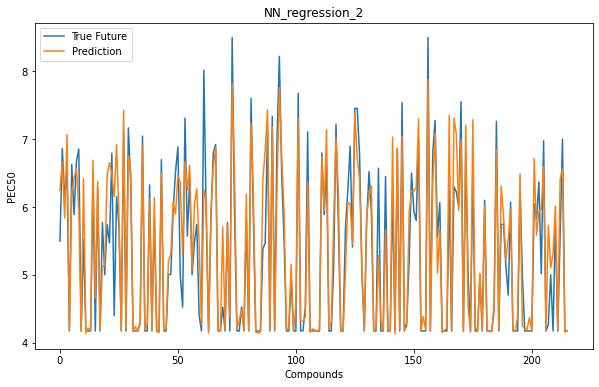

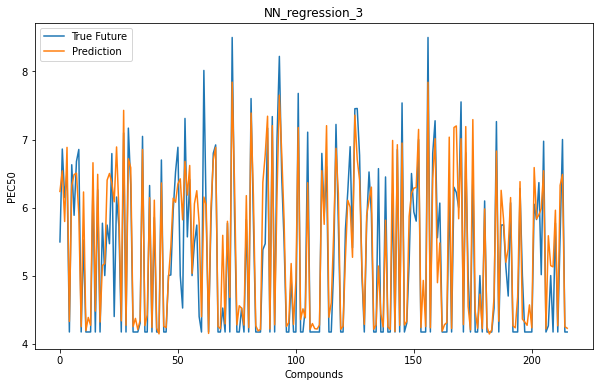

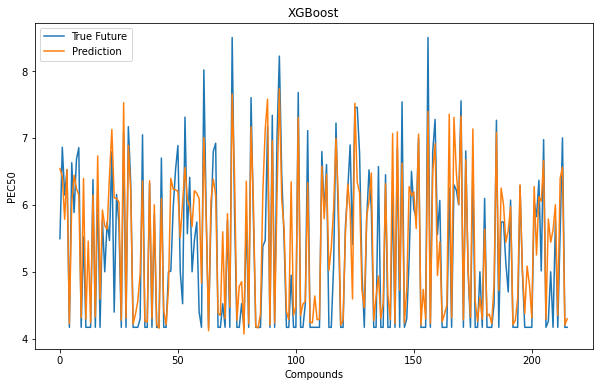

In [63]:
plot_future(prediction_test_nn, scaler.inverse_transform(y_test_nn), "NN_regression")
plot_future(prediction_test_nn_2, scaler.inverse_transform(y_test_nn), "NN_regression_2")
plot_future(prediction_test_nn_3, scaler.inverse_transform(y_test_nn), "NN_regression_3")
plot_future(prediction_test_xgboost, scaler.inverse_transform(y_test_xg), "XGBoost")

In [64]:
res = pd.DataFrame()
res = evaluate_prediction(prediction_test_nn,scaler.inverse_transform(y_test_nn), 'DNN_1',1,res)
res = evaluate_prediction(prediction_test_nn_2,scaler.inverse_transform(y_test_nn), 'DNN_2',1,res)
res = evaluate_prediction(prediction_test_nn_3,scaler.inverse_transform(y_test_nn), 'DNN_3',1,res)
res = evaluate_prediction(prediction_test_nn_4,scaler.inverse_transform(y_test_nn), 'DNN_4',1,res)
res = evaluate_prediction(prediction_test_xgboost,scaler.inverse_transform(y_test_xg), 'XGBoost',1,res)

DNN_1:
Mean Absolute Error: 0.3076
Root Mean Square Error: 0.4761
Mean squared error: 0.2266
DNN_2:
Mean Absolute Error: 0.3021
Root Mean Square Error: 0.4697
Mean squared error: 0.2206
DNN_3:
Mean Absolute Error: 0.3371
Root Mean Square Error: 0.4794
Mean squared error: 0.2299
DNN_4:
Mean Absolute Error: 0.3079
Root Mean Square Error: 0.4933
Mean squared error: 0.2434
XGBoost:
Mean Absolute Error: 0.4058
Root Mean Square Error: 0.5561
Mean squared error: 0.3093


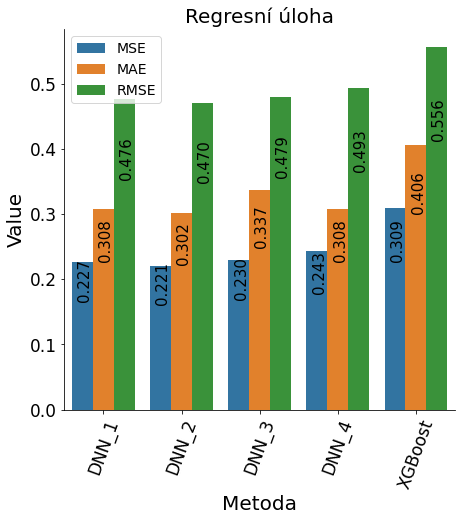

In [65]:
barplot(res,"reg")

# **Classification**

In [66]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import f1_score

Uděláme RNN s pouzitim ruznych architektur, XGBoost pro clasifikáční úlohu a porovnáme mezi sebou výsledky 

# **DNN _1**
3 skryte vrstvy v prvnich dvou 200 neurony, v dalsi 50, pocet epoch=200, batch_size=25

In [67]:
train_set_, test_set = divide_the_data_into_two_sets(df ,2)
train_set, valid_set = divide_the_data_into_two_sets(train_set_ ,2)

In [68]:
x_test_nn=np.stack(test_set.bin.values)
y_test_nn=test_set.category_new.values.reshape((-1,1))
x_train_nn=np.stack(train_set.bin.values)
y_train_nn=train_set.category_new.values.reshape((-1,1))
x_valid_nn=np.stack(valid_set.bin.values)
y_valid_nn=valid_set.category_new.values.reshape((-1,1))

In [69]:
x_train_nn = x_train_nn.reshape((x_train_nn.shape[0],x_train_nn.shape[1]))
x_test_nn = x_test_nn.reshape((x_test_nn.shape[0],x_test_nn.shape[1]))
x_valid_nn = x_valid_nn.reshape((x_valid_nn.shape[0],x_valid_nn.shape[1]))

In [70]:
def model_keras_nn_cl():
  model = Sequential()
  model.add(Dense(200, input_dim=1024, activation='relu'))
  model.add(Dense(200, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  print(model.summary())
  return model
 

In [71]:
model_nn_cl = model_keras_nn_cl()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 200)               205000    
                                                                 
 dense_18 (Dense)            (None, 200)               40200     
                                                                 
 dropout_9 (Dropout)         (None, 200)               0         
                                                                 
 dense_19 (Dense)            (None, 50)                10050     
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 255,301
Trainable params: 255,301
Non-trainable params: 0
_________________________________________________________________
None


In [72]:

history = model_nn_cl.fit(x_train_nn, y_train_nn,
                    epochs=200,
                    batch_size=50,
                    validation_data=(x_valid_nn, y_valid_nn),
                    verbose = 0
                   )

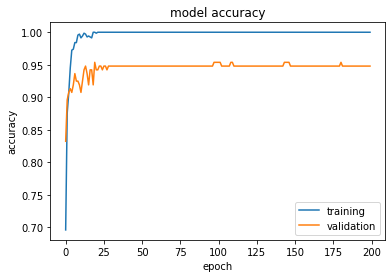

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [74]:
prediction_nn_cl = model_nn_cl.predict(x_test_nn)
prediction_nn_cl = np.where(prediction_nn_cl>=0.5, 1, 0)
prediction_nn_cl[:4]

array([[1],
       [1],
       [0],
       [1]])

In [75]:
scores = model_nn_cl.evaluate(x_test_nn, y_test_nn,verbose=0)
print("DNN_classifier_1")
print("Accuracy: %.2f%%" % (scores[1]*100))
print("F1_score: %.2f%%" % (f1_score(y_test_nn, prediction_nn_cl)*100))

DNN_classifier_1
Accuracy: 84.72%
F1_score: 78.43%


In [76]:
res_cl = pd.DataFrame()
res_cl = res_cl.append({'Metoda':'DNN_1','Accur': (scores[1]),'F1': (f1_score(y_test_nn, prediction_nn_cl))},ignore_index=True)

# **DNN_2**
3 skryte vrstvy, v kazde 500 neuronu, pocet epoch=200, batch_size=50

In [77]:
x_test_nn=np.stack(test_set.bin.values)
y_test_nn=test_set.category_new.values.reshape((-1,1))
x_train_nn=np.stack(train_set.bin.values)
y_train_nn=train_set.category_new.values.reshape((-1,1))
x_valid_nn=np.stack(valid_set.bin.values)
y_valid_nn=valid_set.category_new.values.reshape((-1,1))

In [78]:
x_train_nn = x_train_nn.reshape((x_train_nn.shape[0],x_train_nn.shape[1]))
x_test_nn = x_test_nn.reshape((x_test_nn.shape[0],x_test_nn.shape[1]))
x_valid_nn = x_valid_nn.reshape((x_valid_nn.shape[0],x_valid_nn.shape[1]))

In [79]:
def model_keras_nn_cl_2():
  model = Sequential()
  model.add(Dense(500, input_dim=1024, activation='relu'))
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(500, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  print(model.summary())
  return model
 

In [80]:
model_nn_cl_2 = model_keras_nn_cl_2()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 500)               512500    
                                                                 
 dense_22 (Dense)            (None, 500)               250500    
                                                                 
 dropout_10 (Dropout)        (None, 500)               0         
                                                                 
 dense_23 (Dense)            (None, 500)               250500    
                                                                 
 dense_24 (Dense)            (None, 1)                 501       
                                                                 
Total params: 1,014,001
Trainable params: 1,014,001
Non-trainable params: 0
_________________________________________________________________
None


In [81]:

history = model_nn_cl_2.fit(x_train_nn, y_train_nn,
                    epochs=200,
                    batch_size=50,
                    validation_data=(x_valid_nn, y_valid_nn),
                    verbose = 0
                   )

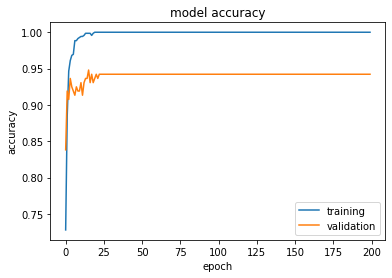

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [83]:
prediction_nn_cl_2 = model_nn_cl_2.predict(x_test_nn)
prediction_nn_cl_2 = np.where(prediction_nn_cl_2>=0.5, 1, 0)
prediction_nn_cl_2[:4]

array([[1],
       [1],
       [0],
       [1]])

In [84]:
scores = model_nn_cl_2.evaluate(x_test_nn, y_test_nn,verbose=0)
print("DNN_classifier_2")
print("Accuracy: %.2f%%" % (scores[1]*100))
print("F1_score: %.2f%%" % (f1_score(y_test_nn, prediction_nn_cl_2)*100))

DNN_classifier_2
Accuracy: 84.72%
F1_score: 77.85%


In [85]:

res_cl = res_cl.append({'Metoda':'DNN_2','Accur': (scores[1]),'F1': (f1_score(y_test_nn, prediction_nn_cl_2))},ignore_index=True)

# **DNN_3**
3 skryte vrstvy, v kazde 1500 neuronu, pocet epoch=200, batch_size=50

In [86]:
x_test_nn=np.stack(test_set.bin.values)
y_test_nn=test_set.category_new.values.reshape((-1,1))
x_train_nn=np.stack(train_set.bin.values)
y_train_nn=train_set.category_new.values.reshape((-1,1))
x_valid_nn=np.stack(valid_set.bin.values)
y_valid_nn=valid_set.category_new.values.reshape((-1,1))

In [87]:
x_train_nn = x_train_nn.reshape((x_train_nn.shape[0],x_train_nn.shape[1]))
x_test_nn = x_test_nn.reshape((x_test_nn.shape[0],x_test_nn.shape[1]))
x_valid_nn = x_valid_nn.reshape((x_valid_nn.shape[0],x_valid_nn.shape[1]))

In [88]:
def model_keras_nn_cl_3():
  model = Sequential()
  model.add(Dense(1500, input_dim=1024, activation='relu'))
  model.add(Dense(1500, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1500, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  print(model.summary())
  return model
 

In [89]:
model_nn_cl_3 = model_keras_nn_cl_3()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 1500)              1537500   
                                                                 
 dense_26 (Dense)            (None, 1500)              2251500   
                                                                 
 dropout_11 (Dropout)        (None, 1500)              0         
                                                                 
 dense_27 (Dense)            (None, 1500)              2251500   
                                                                 
 dense_28 (Dense)            (None, 1)                 1501      
                                                                 
Total params: 6,042,001
Trainable params: 6,042,001
Non-trainable params: 0
_________________________________________________________________
None


In [90]:

history = model_nn_cl_3.fit(x_train_nn, y_train_nn,
                    epochs=200,
                    batch_size=50,
                    validation_data=(x_valid_nn, y_valid_nn),
                    verbose = 0
                   )

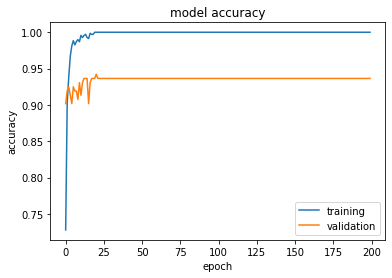

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [92]:
prediction_nn_cl_3 = model_nn_cl_3.predict(x_test_nn)
prediction_nn_cl_3 = np.where(prediction_nn_cl_3>=0.5, 1, 0)
prediction_nn_cl_3[:4]

array([[1],
       [1],
       [0],
       [1]])

In [93]:
scores = model_nn_cl_3.evaluate(x_test_nn, y_test_nn,verbose=0)
print("DNN_classifier_3")
print("Accuracy: %.2f%%" % (scores[1]*100))
print("F1_score: %.2f%%" % (f1_score(y_test_nn, prediction_nn_cl_3)*100))

DNN_classifier_3
Accuracy: 83.80%
F1_score: 76.51%


In [94]:

res_cl = res_cl.append({'Metoda':'DNN_3','Accur': (scores[1]),'F1': (f1_score(y_test_nn, prediction_nn_cl_3))},ignore_index=True)

# **DNN_4**
4 skryte vrstvy, vsechny maji 500 neuronu, pocet epoch=200, batch_size=50

In [95]:
x_test_nn=np.stack(test_set.bin.values)
y_test_nn=test_set.category_new.values.reshape((-1,1))
x_train_nn=np.stack(train_set.bin.values)
y_train_nn=train_set.category_new.values.reshape((-1,1))
x_valid_nn=np.stack(valid_set.bin.values)
y_valid_nn=valid_set.category_new.values.reshape((-1,1))

In [96]:
x_train_nn = x_train_nn.reshape((x_train_nn.shape[0],x_train_nn.shape[1]))
x_test_nn = x_test_nn.reshape((x_test_nn.shape[0],x_test_nn.shape[1]))
x_valid_nn = x_valid_nn.reshape((x_valid_nn.shape[0],x_valid_nn.shape[1]))

In [97]:
def model_keras_nn_cl_4():
  model = Sequential()
  model.add(Dense(500, input_dim=1024, activation='relu'))
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(500, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  print(model.summary())
  return model
 

In [98]:
model_nn_cl_4 = model_keras_nn_cl_4()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 500)               512500    
                                                                 
 dense_30 (Dense)            (None, 500)               250500    
                                                                 
 dropout_12 (Dropout)        (None, 500)               0         
                                                                 
 dense_31 (Dense)            (None, 500)               250500    
                                                                 
 dropout_13 (Dropout)        (None, 500)               0         
                                                                 
 dense_32 (Dense)            (None, 500)               250500    
                                                                 
 dense_33 (Dense)            (None, 1)                

In [99]:

history = model_nn_cl_4.fit(x_train_nn, y_train_nn,
                    epochs=200,
                    batch_size=50,
                    validation_data=(x_valid_nn, y_valid_nn),
                    verbose = 0
                   )

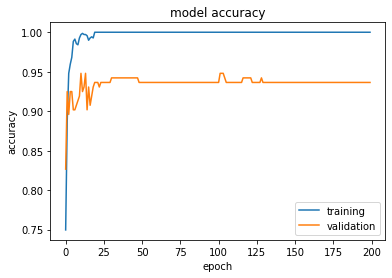

In [100]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [101]:
prediction_nn_cl_4 = model_nn_cl_3.predict(x_test_nn)
prediction_nn_cl_4 = np.where(prediction_nn_cl_4>=0.5, 1, 0)
prediction_nn_cl_4[:4]

array([[1],
       [1],
       [0],
       [1]])

In [102]:
scores = model_nn_cl_4.evaluate(x_test_nn, y_test_nn,verbose=0)
print("DNN_classifier_4")
print("Accuracy: %.2f%%" % (scores[1]*100))
print("F1_score: %.2f%%" % (f1_score(y_test_nn, prediction_nn_cl_4)*100))

DNN_classifier_4
Accuracy: 82.41%
F1_score: 76.51%


In [103]:

res_cl = res_cl.append({'Metoda':'DNN_4','Accur': (scores[1]),'F1': (f1_score(y_test_nn, prediction_nn_cl_4))},ignore_index=True)

# **XGBoost**

In [104]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [105]:
train_set_, test_set = divide_the_data_into_two_sets(df ,2)

In [106]:
x_test_xg=np.stack(test_set.bin.values)
y_test_xg=test_set.category_new.values.reshape((-1,1))
x_train_xg=np.stack(train_set.bin.values)
y_train_xg=train_set.category_new.values.reshape((-1,1))


In [107]:
x_train_xg.shape

(691, 1024)

In [108]:
model_xg_cl = XGBClassifier()

In [109]:
model_xg_cl.fit(x_train_xg, y_train_xg)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier()

In [110]:
prediction_xg_cl = model_xg_cl.predict(x_test_xg)

In [111]:
print("XGBoost_classifier")
print("Accuracy: %.2f%%" % (accuracy_score(y_test_xg, prediction_xg_cl)*100))
print("F1_score: %.2f%%" % (f1_score(y_test_xg, prediction_xg_cl)*100))

XGBoost_classifier
Accuracy: 86.57%
F1_score: 80.00%


In [112]:
res_cl = res_cl.append({'Metoda':'XGBoost','Accur': (accuracy_score(y_test_xg, prediction_xg_cl)),'F1': (f1_score(y_test_xg, prediction_xg_cl))},ignore_index=True)

In [113]:
res_cl

Accur        F1   Metoda
0  0.847222  0.784314    DNN_1
1  0.847222  0.778523    DNN_2
2  0.837963  0.765101    DNN_3
3  0.824074  0.765101    DNN_4
4  0.865741  0.800000  XGBoost

# **Porovnání**

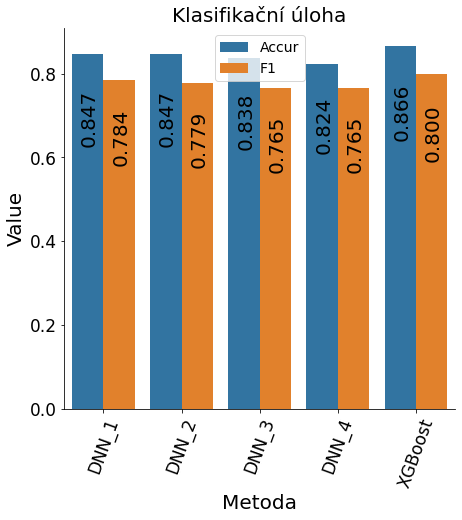

In [114]:
barplot(res_cl, "clas")